# Stochastic Thermostats

Test System
-----------

We will test the effectiveness of different thermostats on a set of decoupled harmonic oscillators. For this system, thermal expectation values and time-correlation functions under the action of a (generalised) Langevin thermostat can be calculated analytically. The frequencies of our oscillators are taken from the 12-mode discretization of the exponentially damped Ohmic spectral density with a cut-off $\omega_{\text{c}} = 500~\text{cm}^{-1}$, spanning values from $21~\text{cm}^{-1}$ to $1589~\text{cm}^{-1}$.

$$
\omega_i = -\omega_{\text{c}} \log\left(
    \frac{i - 1/2}{n_{\text{bath}}}
\right) \qquad i = 1,\ldots,n_{\text{bath}}.
$$
I am taking $n_{\text{bath}} = 12$, so that the highest frequency
$$
\omega_1 = \omega_{\text{c}} \log\left(
    2 n_{\text{bath}}
\right) = 1589~\text{cm}^{-1}
$$
and the lowest frequency
$$
\omega_{n_{\text{bath}}} = -\omega_{\text{c}} \log\left(
    1 - \frac{1}{2 n_{\text{bath}}}
\right) \sim \frac{\omega_{\text{c}}}{2 n_{\text{bath}}} = 21~\text{cm}^{-1}
$$
The temperature is set to 300~K and the particle mass to that of a proton, $m = m_p = 1836.153~m_e$. For reference, the thermal expectation values for the squared position and momentum of a harmonic oscillator are
$$
    \left\langle  x^2  \right\rangle = \frac{1}{\beta m \omega^2} \qquad \text{and} \qquad \left\langle  p^2  \right\rangle = \frac{m}{\beta}
$$
and we can use Isserlis's theorem to compute the higher moments,
$$
    \left\langle  q^4  \right\rangle = 3 \left\langle  q^2  \right\rangle^2 \qquad \qquad (q = x \text{ or } p) .
$$
For Langevin equation thermostats, we can use the analytical expressions for the time-correlation of processes described by the Ornstein-Uhlenbeck equation. In mass weighted coordinates,
$$
\begin{pmatrix}
    x(0) \\
    p(0) \\
    \mathbf{s}(0)
\end{pmatrix}
\begin{pmatrix}
    x(t) & p(t) & \mathbf{s}(t)^{\intercal}
\end{pmatrix}
= \mathrm{e}^{-\mathbf{A}_{xp} t} \mathbf{C}
$$
where $\mathbf{A}_{xp}$ is the drift matrix described, e.g., by Ceriotti et al. in _J. Chem. Theory Comput._ **6**, 1170–1180, (2010) and 
$$
C_{i,j} = \begin{cases}
1/\beta \omega^2 & i = j = 1 \\
1/\beta & \text{otherwise}
\end{cases}
$$
For the special cases of a white-noise Langevin thermostat (WNLE) with friction $\gamma = 1/\tau$,
$$
\left\langle x(0) x(t)\right\rangle = 
\frac{
    \mathrm{e}^{-t / 2 \tau}
}{
    \beta m \omega^2
} \times 
\begin{cases}
    \cos(\Omega t) + \frac{1}{2\Omega\tau} \sin(\Omega t) &  \tau > \frac{1}{2 \omega} \\
    \cosh(\Omega t) + \frac{1}{2 \Omega \tau} \sinh( \Omega t) &  \tau < \frac{1}{2 \omega} \\
    1 + \frac{t}{2 \tau} &  \tau = \frac{1}{2 \omega}
\end{cases}
$$
where $\Omega = \sqrt{ \lvert \omega^2 - (1/2 \tau)^2 \rvert } $.
Again from Isserlis',
$$
\left\langle x(0)^2 x(t)^2 \right\rangle = 2 \left\langle x(0) x(t) \right\rangle^2 + \left\langle x^2 \right\rangle^2.
$$

## White-noise Langevin equation thermostat (WNLE)

From the analytical expression for the position auto-correlation function, it can be shown that the fastest possible decorrelation time when the observable is potential energy ($x^2$) is achieved for $\tau = 1/\omega$. When the time constant is above this value, the system is underdamped and the decay timescale asymptotically tends to $\tau$ as $\tau \gg \omega^{-1}$. Therefore, when using a WNLE thermostat for a highly harmonic system, it is best to choose $\tau$ based on the *lowest* relevant frequency (in our case this corresponds to 250 fs). **NOTE** as a general rule of thumb, $\tau = 500~\text{fs}$ matches a lowest frequency of $10~\text{cm}^{-1}$. Doubling the frequency halves the optimal relaxation time.

In [1]:
import stochastic
from units import SI, sc, atomic
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib widget

T = 300.0 # K
u = atomic() # unit system
beta = u.betaTemp(T)
nbath = 12
# Plot layout for different numbers of bath modes
layout = { 9: (3,3), 12: (3,4), 16: (4,4), 24: (4,6), 36: (6,6), 48: (6,8), 64: (8,8) }
wc = u.wn2omega(500) # frequency cut-off 500 cm^-1
mass = sc.m_p / u.mass # proton mass in system units

def expohmic_freqs(nbath: int, omega_cut: float) -> np.ndarray:
    """Calculate the harmonic discretization into `nbath` modes of
    an exponentially damped Ohmic spectral density with cutoff `omega_cut`
    according to Craig and Manolopoulos (2004), https://doi.org/10.1063/1.1850093
    """
    w = -omega_cut * np.log(
        (np.arange(1, nbath+1)-1/2) / nbath
    )[::-1]
    return w

# Analytical results for potential/kinetic energies and their squares
bath_freqs = expohmic_freqs(nbath, wc)
x2avg = 1/(beta*mass*bath_freqs**2)
x4avg = 3*x2avg**2
p2avg = mass/beta
p4avg = 3*p2avg**2


In [2]:
# bath frequencies:
print(f"𝜔 / cm^(-1) = \n{u.omega2wn(bath_freqs)}")
# optimal thermostatting parameters
print(f"𝜏 / fs = \n{1/bath_freqs * u.time / sc.femto}")

𝜔 / cm^(-1) = 
[  21.27980721   66.76569631  116.80742559  172.42024315  235.00181462
  306.55223644  390.07927877  490.41462651  616.07184065  784.30795896
 1039.72077084 1589.02691517]
𝜏 / fs = 
[249.47770469  79.51444757  45.44948604  30.7901054   22.59062326
  17.31788853  13.60963719  10.82520213   8.61723765   6.76881753
   5.10602232   3.34093615]


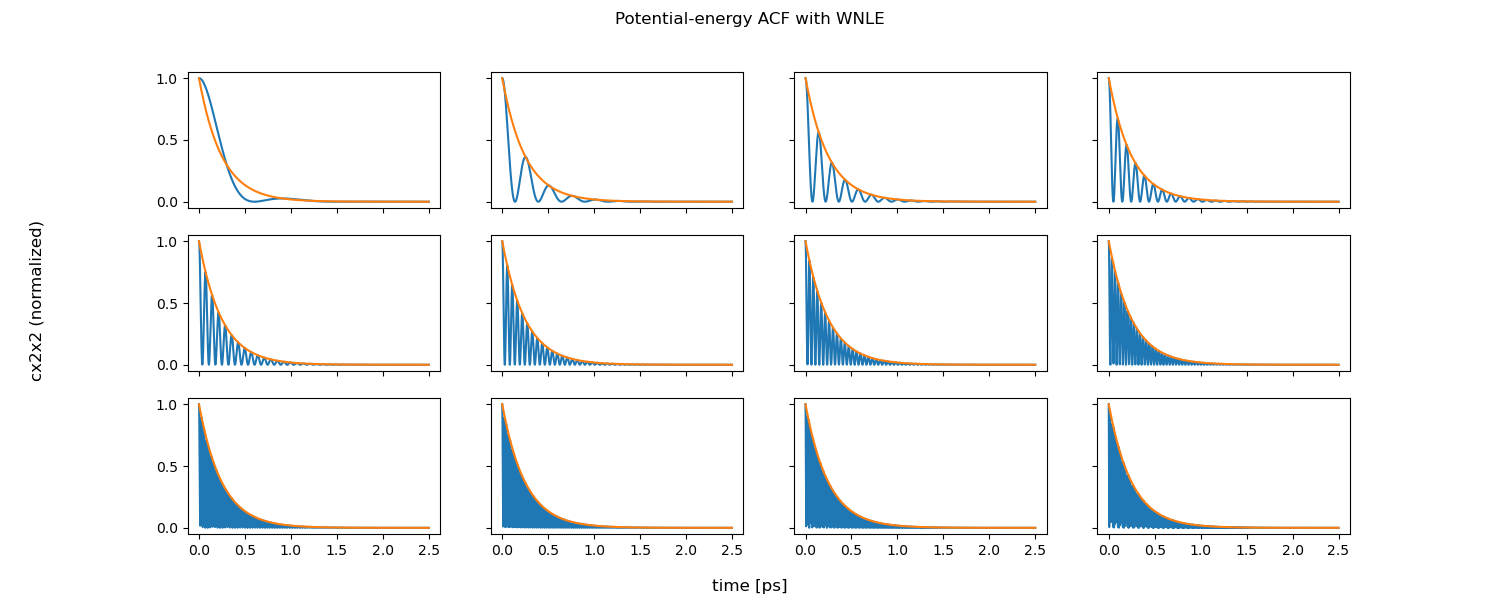

In [5]:
# Plot potential-energy auto-correlation function for each mode
tmax = 2.5 # ps
npts = 1000
t_ps = np.linspace(0, tmax, npts)
t = t_ps * u.str2base("1 ps")  # in internal units
r, c = layout[nbath]
fig, axarr = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True)
fig.set_size_inches([15, 6])
# optimal thermostatting constant for the slowest mode
tau = 1/np.min(bath_freqs)
# change this to scale tau and see how that affects the decorrelation times
lamda = 1.0
for i, ax in enumerate(np.ravel(axarr)):
    # Analytical time-correlation function
    ax.plot(t_ps, (2*stochastic.wnle_cqq(t, beta, bath_freqs[i], lamda*tau, mass)**2)
                  / (x4avg[i] - x2avg[i]**2))
    # Envelope
    ax.plot(t_ps, np.exp(-t/tau))
fig.suptitle("Potential-energy ACF with WNLE")
fig.supxlabel("time [ps]");
fig.supylabel("cx2x2 (normalized)");

## Generalized Langevin equation thermostat (GLE)

A GLE offers significantly greater flexibility and the key point is that, compared to a WNLE, it can enhance the sampling accuracy of the higher frequency modes without much detriment to the sampling of slow harmonic motion. The following example uses a drift matrix taken from [gle4md.org](gle4md.org) using a *Smart sampling* GLE type with the slowest sampling timescale set to 2 ps, the number of auxiliary DoFs = 6, $\omega_{\mathrm{max}} / \omega_{\mathrm{min}} = 100$.

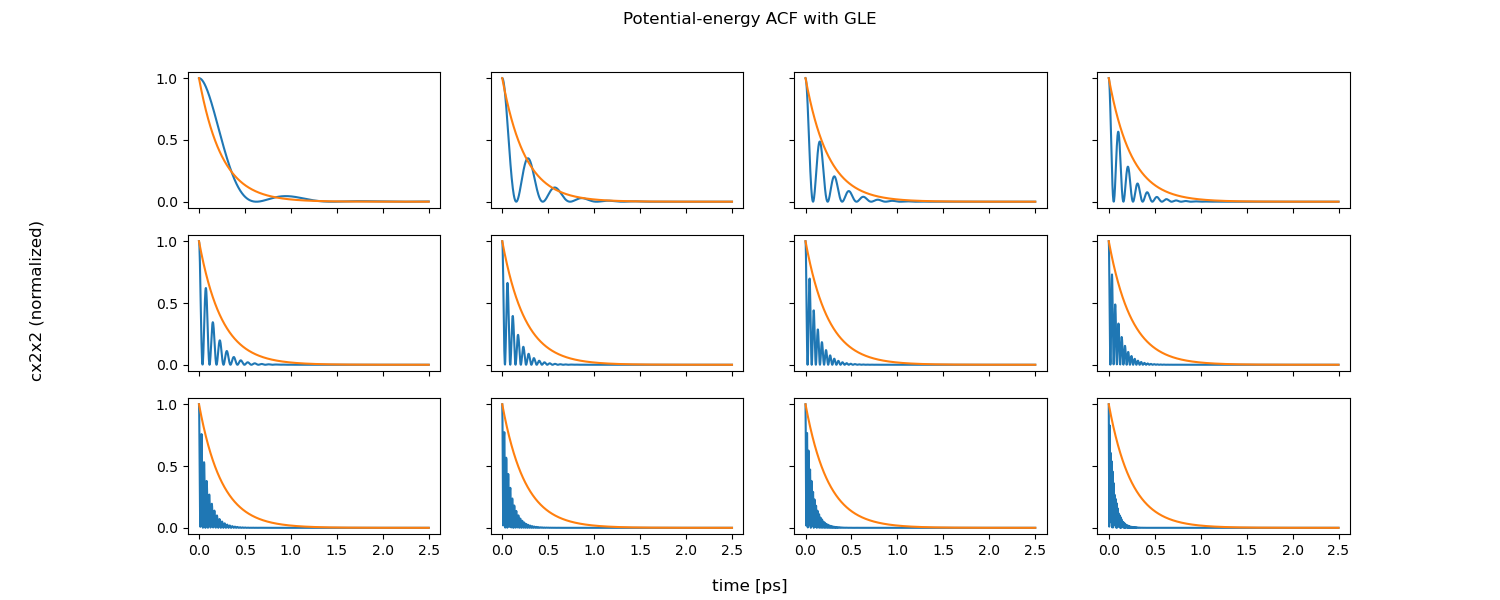

In [6]:
with open("gle.json", "r") as f:
    A_pp = np.asarray(json.load(f)["A"])
fig, axarr = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True)
fig.set_size_inches([15, 6])
for i, ax in enumerate(np.ravel(axarr)):
    ref_tcf = stochastic.gle_cxx(t, beta, bath_freqs[i], A_pp, mass=mass)
    cxx = ref_tcf[:,0,0]
    ax.plot(t_ps, 2*cxx**2 / (x4avg[i] - x2avg[i]**2))
    ax.plot(t_ps, np.exp(-t/tau))
fig.suptitle("Potential-energy ACF with GLE")
fig.supxlabel("time [ps]");
fig.supylabel("cx2x2 (normalized)");

## Stochastic velocity rescaling (SVR)

Lastly, we turn to the stochastic velocity rescaling thermostat (SVR). This, essentially, propagates the total kinetic energy according to a stochastic differential equation designed to preserve the Boltzmann distribution for the *total* kinetic energy. The thermalisation of other collective variables is not guaranteed and will be poor for our highly harmonic test case. There are no analytical results, the output of some numerical simulations is shown below.

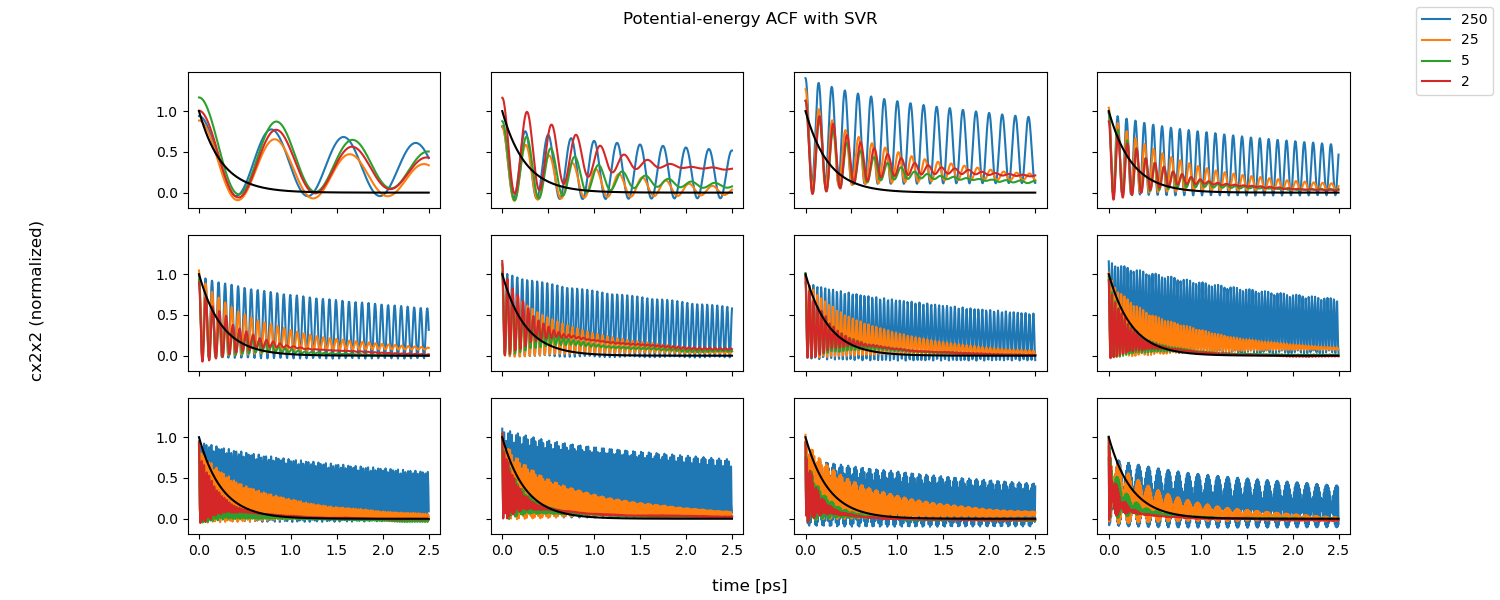

In [7]:
fig, axarr = plt.subplots(nrows=r, ncols=c, sharex=True, sharey=True)
fig.set_size_inches([15, 6])
svr_tau = [250, 25, 5, 2]  # thermostat constant in fs
data = []
for datum in svr_tau:
    data.append(pd.read_csv(f'svr_{datum:03d}_cx2x2.csv', index_col=0, sep='\s+', header=None, skiprows=1))
lines = []
for i, ax in enumerate(np.ravel(axarr)):
    for df in data:
        line, = ax.plot(df.index, (df[2*i+1] - x2avg[i]**2) / (x4avg[i] - x2avg[i]**2))
        if i == 0:
            lines.append(line)
    ax.plot(t_ps, np.exp(-t/tau), c='k')
fig.suptitle("Potential-energy ACF with SVR")
fig.supxlabel("time [ps]");
fig.supylabel("cx2x2 (normalized)");
fig.legend(lines, svr_tau);